<a href="https://colab.research.google.com/github/kidrono/PyTorch-Food-Classification/blob/main/pytorch_food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import requests
import zipfile
from pathlib import Path
data_path = Path("data/")
img_path = data_path / "pizza_steak_sushi"

if img_path.is_dir():
  print("already exists")
else:
  img_path.mkdir(parents=True, exist_ok=True)




In [4]:
with open(data_path/"pizza_steak_sushi.zip", 'wb') as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", 'r') as zip_ref:
  zip_ref.extractall(img_path)

downloading data


In [5]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirname, filename in os.walk(dir_path):
    print(f"There are {len(dirname)} directories and {len(filename)} images in {dirpath}")

In [6]:
walk_through_dir(img_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak


In [7]:
train_dir = img_path / "train"
test_dir = img_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

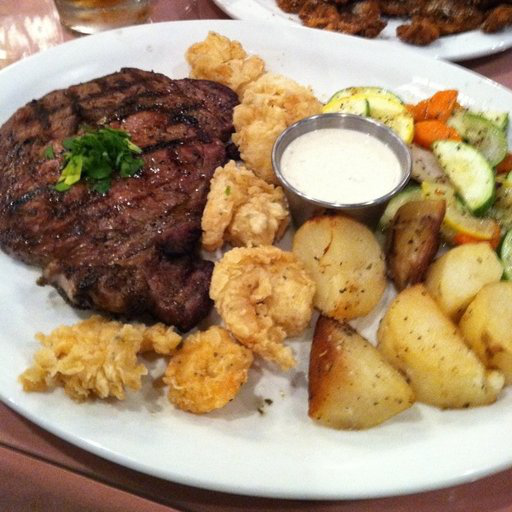

In [8]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(img_path.glob("*/*/*.jpg"))

rand_img_path = random.choice(image_path_list)

img_class = rand_img_path.parent.stem

img = Image.open(rand_img_path)

img

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
data_transform = transforms.Compose([transforms.Resize(size=(64,64)), 
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

In [11]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [12]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

In [13]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f199f280910>,
 <torch.utils.data.dataloader.DataLoader at 0x7f199f2808e0>)

In [14]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([32, 3, 64, 64])

## Costum Dataset

In [15]:
import os
import pathlib
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [16]:
target_directory = train_dir

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [17]:
def find_classes(directory):
  class_names_found = sorted([entry.name for entry in list(os.scandir(directory))])
  class_to_idx = {class_name: i for i, class_name in enumerate(class_names_found)}
  return class_names_found, class_to_idx

In [18]:
class ImageFolderCostume(Dataset):
  def __init__(self, target_dir, transform=None) -> None:
    super().__init__()
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idf = find_classes(target_dir)

  def load_image(self, index):
    image_path = self.paths[index]
    return Image.open(image_path)
  
  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [19]:
train_transform = transforms.Compose([transforms.Resize(size=(64,64)), 
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(64,64)), 
                                     transforms.ToTensor()])

In [20]:
train_data_custom = ImageFolderCostume(target_dir=train_dir, transform=train_transform)

test_data_custom = ImageFolderCostume(target_dir=test_dir, transform=test_transform)

In [21]:
import matplotlib.pyplot as plt

In [22]:
def display_random_images(dataset, classes, n=10, dislay_shape=True, seed=None):
  if n > 10:
    n = 10
    display_shape = False
  if seed:
    random.seed(seed)
  random_samples_idx = random.sample(range(len(dataset)), k=n)
  for i, targ_sample in enumerate(random_samples_idx):
    img, lbl = dataset[targ_sample][0], dataset[targ_sample][1]
    img_permute = img.permute(1,2,0)
    plt.subplot(1, n, i+1)
    plt.imshow(img_permute)
    plt.axis(False)
    plt.title(classes[lbl])

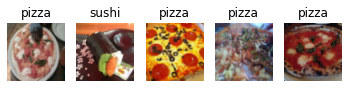

In [23]:
display_random_images(train_data, class_names, n=5)

In [24]:
NUM_WORKERS = os.cpu_count()

train_dataloader_costume = DataLoader(dataset=train_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=0,
                                      shuffle=True)

test_dataloader_costume = DataLoader(dataset=test_data_custom,
                                      batch_size=BATCH_SIZE,
                                      num_workers=0,
                                      shuffle=False)

In [25]:
test_dataloader_costume

## Some Data Augmantation

In [26]:
train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor()])

## Baseline Model - tiny VGG without augmantation

In [27]:
baseline_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                         transforms.ToTensor()])

In [28]:
baseline_train_data = datasets.ImageFolder(root=train_dir, transform=baseline_transform)
baseline_test_data = datasets.ImageFolder(root=test_dir, transform=baseline_transform)

BATCH = 32
WORKERS = os.cpu_count()

baseline_train_dataloader = DataLoader(dataset=baseline_train_data,
                                       batch_size=BATCH,
                                       shuffle=True,
                                       num_workers=WORKERS)

baseline_test_dataloader = DataLoader(dataset=baseline_test_data,
                                       batch_size=BATCH,
                                       shuffle=False,
                                       num_workers=WORKERS)

In [29]:
class TinyVGG(nn.Module):

  def __init__(self, input, hidden, output) -> None:
    super().__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(input, hidden, 3, 1, 1),
                               nn.ReLU(),
                               nn.Conv2d(hidden, hidden, 3, 1, 1),
                               nn.ReLU(),
                               nn.MaxPool2d(2, 2))
    self.conv2 = nn.Sequential(nn.Conv2d(hidden, hidden, 3, 1, 1),
                               nn.ReLU(),
                               nn.Conv2d(hidden, hidden, 3, 1, 1),
                               nn.ReLU(),
                               nn.MaxPool2d(2, 2))
    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(hidden * 16 * 16, output))
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.classifier(x)
    return x

In [30]:
torch.manual_seed(42)
model0 = TinyVGG(3, 10, 3).to(device)

image_batch, label_batch = next(iter(baseline_train_dataloader))
image_batch = image_batch.to(device)
model0(image_batch)

tensor([[0.0578, 0.0634, 0.0352],
        [0.0658, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0375],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0348],
        [0.0620, 0.0599, 0.0370],
        [0.0607, 0.0628, 0.0387],
        [0.0637, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0690, 0.0330],
        [0.0557, 0.0570, 0.0357],
        [0.0631, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0369],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0638, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

In [31]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import torchinfo
torchinfo.summary(model0, [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [47]:
def train_step(model, data_loader, loss_fn, optimizer):
  model.train()
  train_loss = 0
  train_acc = 0
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum() / len(y)
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  return train_loss, train_acc

In [48]:
def test_step(model, data_loader, loss_fn):
  model.eval()
  test_loss = 0
  test_acc = 0
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_preds = model(X)
      loss = loss_fn(y_preds, y)
      test_loss += loss.item()
      y_class = torch.argmax(torch.softmax(y_preds, dim=1), dim=1)
      acc = (y_class == y).sum() / len(y)
      test_acc += acc
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    return test_loss, test_acc

In [52]:
from tqdm.auto import tqdm
def train_model(model, train_data_loader, 
                test_data_loader, loss_fn, 
                optimizer, epochs=5):
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_data_loader,
                                       loss_fn, optimizer)
    test_loss, test_acc = test_step(model, test_data_loader, loss_fn)
    print(f"Epoch: {epoch} | Train loss: {train_loss} | Train accuracy: {train_acc}")
    print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")
    print()
  

In [53]:
from timeit import default_timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model0.parameters(), 0.001)

start_time = default_timer()

results = train_model(model0, baseline_train_dataloader, baseline_test_dataloader,
                      loss_fn, optimizer)

end_time = default_timer()
print(f"Total time took to train: {end_time - start_time} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.8553885817527771 | Train accuracy: 0.640625
Test loss: 1.0369505683581035 | Test accuracy: 0.3920454680919647

Epoch: 1 | Train loss: 0.8319301456212997 | Train accuracy: 0.625
Test loss: 1.0619817574818928 | Test accuracy: 0.38257575035095215

Epoch: 2 | Train loss: 0.7754140496253967 | Train accuracy: 0.62890625
Test loss: 1.0761926571528118 | Test accuracy: 0.40340909361839294

Epoch: 3 | Train loss: 0.849015548825264 | Train accuracy: 0.578125
Test loss: 1.0531336069107056 | Test accuracy: 0.4337121248245239

Epoch: 4 | Train loss: 0.7543192356824875 | Train accuracy: 0.67578125
Test loss: 1.0652259588241577 | Test accuracy: 0.4232954680919647

Total time took to train: 8.412426880999874 seconds
